# Mini Mobilenet

In order to test the DPU model's separate convolution engines, this notebook trains a simple network featureing depthwise separable convolution.

Based on Assignment 3 code.

## Part 1
Fill in object class named `ConvNet` in `cnn_model.py`. You’ll define the network layers in the method `__init__` and the forward pass in the method `forward`. We create an instance of `ConvNet` in `train.py`, which takes a tensor with dimension $(B, 3, 32, 32)$ as an input, where $B$ is the batch size. The output should be a matrix of dimension $(B, 10)$ representing the confidence (before applying the softmax function) for the 10 categories. Your CNN should have 4 convolutional layers with ReLU, Dropout, Batch Normalization and Max pooling operations in each (if required), followed by a linear layer and then a classifier layer at the end. You can use the function `_initialize_weight` in `ConvNet` to initialize weights of the convolutional layers. You are allowed to choose stride, weight decay, dropout rate, filter kernel size, number of output feature maps for each layer and other hyper-parameters. FYI: A 4 layer network (written properly) should be able to obtain at least an accuracy of 65% on the test set.

In [1]:
########################################################################
# 2. DEFINE YOUR CONVOLUTIONAL NEURAL NETWORK
########################################################################

import torch.nn as nn
import torch.nn.functional as F

class DwConv(nn.Module):
	def __init__(self, in_channels, out_channels, kernel_size):
		super(DwConv, self).__init__()
		self.depthwise = nn.Conv2d(
			in_channels, in_channels,
			kernel_size=kernel_size, padding=kernel_size//2,
			groups=in_channels
		)
		self.pointwise = nn.Conv2d(
			in_channels, out_channels,
			kernel_size=1
		)
	def forward(self, x):
		return self.pointwise(
			self.depthwise(x)
		)

class ConvNet(nn.Module):
	def __init__(self, init_weights=False):
		super(ConvNet, self).__init__()
		self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=3)
		self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
		self.conv2 = DwConv(in_channels=6, out_channels=16, kernel_size=3)
		self.fc1 = nn.Linear(in_features=16*7*7, out_features=84)
		self.fc2 = nn.Linear(in_features=84, out_features=10)

	def forward(self, x):
		x = self.pool(F.relu(self.conv1(x)))
		x = self.pool(F.relu(self.conv2(x)))
		x = x.view(-1, 16*7*7)
		x = F.relu(self.fc1(x))
		out = self.fc2(x)
		return out

## Part 2
Fill in loss function with cross-entropy loss and write the code to obtain accuracy of current batch of data.

In [2]:
"""
---------------------------------------------------------------------
Training an image classifier
---------------------------------------------------------------------
For this assingment you'll do the following steps in order:
1. Load and normalizing the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolutional Neural Network (at least 4 conv layer)
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data
---------------------------------------------------------------------
"""

# IMPORTING REQUIRED PACKAGES
import os
import numpy as np
import scipy.io as sio
import torch
import torchvision
import torchvision.transforms as transforms


# DEFINE VARIABLE
BATCH_SIZE = 32
EPOCH_NUM = 100
LR = 0.001
MODEL_SAVE_PATH = './Models'

if not os.path.exists(MODEL_SAVE_PATH):
	os.mkdir(MODEL_SAVE_PATH)

# DEFINING TRANSFORM TO APPLY TO THE IMAGES
# YOU MAY ADD OTHER TRANSFORMS FOR DATA AUGMENTATION
transform = transforms.Compose([
	transforms.Resize(32),
	transforms.ToTensor(),
	transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


########################################################################
# 1. LOAD AND NORMALIZE CIFAR10 DATASET
########################################################################

#FILL IN: Get train and test dataset from torchvision and create respective dataloader
trainset = torchvision.datasets.CIFAR10(
	root='./data', train=True,
	download=True, transform=transform
)
trainloader = torch.utils.data.DataLoader(
	trainset, batch_size=BATCH_SIZE
)

testset =torchvision.datasets.CIFAR10(
	root='./data', train=False,
	download=True, transform=transform
)
testloader = torch.utils.data.DataLoader(
	trainset, batch_size=BATCH_SIZE
)

########################################################################
# 2. DEFINE YOUR CONVOLUTIONAL NEURAL NETWORK AND IMPORT IT
########################################################################


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = ConvNet().to(device) #MAKE SURE TO DEFINE ConvNet IN A CELL ABOVE THE STARTER CODE OF WHICH IS IN cnn_model.py
#You can pass arguments to ConvNet if you want instead of hard coding them.


########################################################################
# 3. DEFINE A LOSS FUNCTION AND OPTIMIZER
########################################################################

import torch.optim as optim

#FILL IN : the criteria for ce loss
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=LR, momentum=0.9)

## Part 3
Fill in to obtain test accuracy over the entire test set and append it to the test accuracy variable.

In [3]:
########################################################################
# 4. TRAIN THE NETWORK
########################################################################

test_accuracy = []
test_loss = []
train_accuracy = []
train_loss = []
net.train()

for epoch in range(EPOCH_NUM):  # loop over the dataset multiple times

	running_loss = 0.0
	test_min_acc = 0
	total = 0
	correct = 0

	for i, data in enumerate(trainloader, 0):
		# get the inputs
		inputs, labels = data

		# zero the parameter gradients
		optimizer.zero_grad()

		# forward + backward + optimize
		outputs = net(inputs.to(device))
		loss = criterion(outputs, labels.to(device))
		loss.backward()
		optimizer.step()

		# print statistics
		running_loss += loss.item()
		_, predicted = torch.max(outputs.data, 1)

		# FILL IN: Obtain accuracy for the given batch of TRAINING data using
		# the formula acc = 100.0 * correct / total where
		# total is the toal number of images processed so far
		# correct is the correctly classified images so far

		total += predicted.shape[0]
		correct += np.sum((predicted.cpu() == labels).numpy())

		train_loss.append(running_loss/20)
		train_accuracy.append(100.0*correct/total)

		if i % 20 == 19:    # print every 20 mini-batches
			print(
				'Train: [%d, %5d] loss: %.3f acc: %.3f' %
				(epoch + 1, i + 1, running_loss / 20,100.0*correct/total)
			)
			running_loss = 0.0

	# TEST LEARNT MODEL ON ENTIRE TESTSET
	# FILL IN: to get test accuracy on the entire testset and append
	# it to the list test_accuracy

	running_loss = 0.0
	correct = 0
	total = 0
	net.eval()
	with torch.no_grad():
		for data in testloader:
			#
			inputs, labels = data
			outputs = net(inputs.to(device))
			#
			running_loss += loss.item()
			_, predicted = torch.max(outputs.data, 1)
	 		#
			total += predicted.shape[0]
			correct += np.sum((predicted.cpu() == labels).numpy())
	 		#
			test_loss.append(running_loss/20)
			test_accuracy.append(100.0*correct/total)

	net.train()

	test_ep_acc = test_accuracy[-1]
	print('Test Accuracy: %.3f %%' % (test_ep_acc))

	# SAVE BEST MODEL
	if test_min_acc < test_ep_acc:
		test_min_acc = test_ep_acc
		torch.save(net,MODEL_SAVE_PATH + '/my_best_model.pth')


# PLOT THE TRAINING LOSS VS EPOCH GRAPH
# PLOT THE TESTING ACCURACY VS EPOCH GRAPH
# PRINT THE FINAL TESTING ACCURACY OF YOUR BEST MODEL

print('Finished Training')

Streaming output truncated to the last 5000 lines.
Train: [37,  1160] loss: 0.618 acc: 78.314
Train: [37,  1180] loss: 0.677 acc: 78.279
Train: [37,  1200] loss: 0.674 acc: 78.242
Train: [37,  1220] loss: 0.578 acc: 78.274
Train: [37,  1240] loss: 0.644 acc: 78.289
Train: [37,  1260] loss: 0.588 acc: 78.299
Train: [37,  1280] loss: 0.649 acc: 78.303
Train: [37,  1300] loss: 0.657 acc: 78.250
Train: [37,  1320] loss: 0.651 acc: 78.236
Train: [37,  1340] loss: 0.599 acc: 78.230
Train: [37,  1360] loss: 0.684 acc: 78.194
Train: [37,  1380] loss: 0.667 acc: 78.182
Train: [37,  1400] loss: 0.635 acc: 78.196
Train: [37,  1420] loss: 0.624 acc: 78.189
Train: [37,  1440] loss: 0.610 acc: 78.205
Train: [37,  1460] loss: 0.643 acc: 78.196
Train: [37,  1480] loss: 0.637 acc: 78.228
Train: [37,  1500] loss: 0.662 acc: 78.221
Train: [37,  1520] loss: 0.600 acc: 78.226
Train: [37,  1540] loss: 0.559 acc: 78.269
Train: [37,  1560] loss: 0.633 acc: 78.273
Test Accuracy: 76.526 %
Train: [38,    20] los

## Part 4
Plot training loss, train accuracy and test accuracy from the saved variables. Can you infer based on the plots, whether the model is overfitted, under-fitted or perfectly fitted?

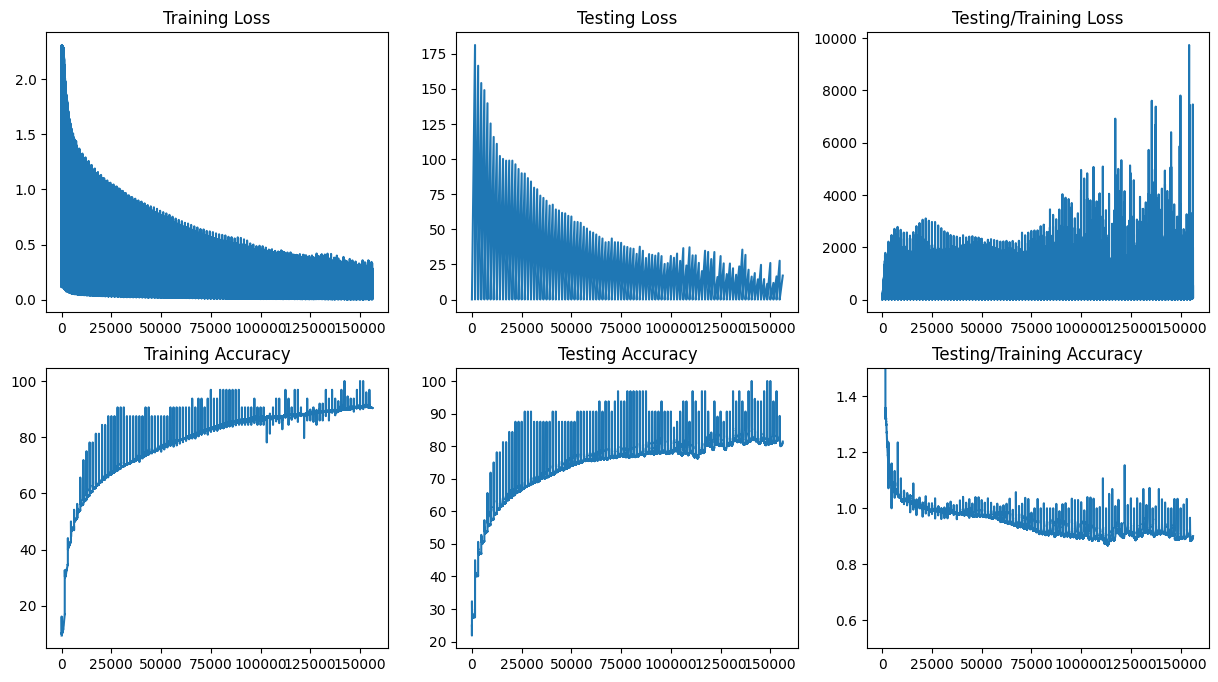

In [4]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2, 3, figsize=(15,8))
axs[0,0].set_title("Training Loss")
axs[0,0].plot(train_loss)
axs[0,1].set_title("Testing Loss")
axs[0,1].plot(test_loss)
axs[0,2].set_title("Testing/Training Loss")
axs[0,2].plot(np.array(test_loss) / np.array(train_loss))
axs[1,0].set_title("Training Accuracy")
axs[1,0].plot(train_accuracy)
axs[1,1].set_title("Testing Accuracy")
axs[1,1].plot(test_accuracy)
axs[1,2].set_title("Testing/Training Accuracy")
axs[1,2].set_ylim([0.5, 1.5])
axs[1,2].plot(np.array(test_accuracy) / np.array(train_accuracy))

Model is well fitted because training and testing accuracy are very similar throughout the training process. Testing accuracy generally remains around 90% of training accuracy for most of the test, so there is slight over-fitting, but not enough to significantly impact model functionality.

In [6]:
from weight_extractor import extract_weights

extract_weights(net, "mininet_weights.json")

Parsing conv1.weight...
Parsing conv1.bias...
Parsing conv2.depthwise.weight...
Parsing conv2.depthwise.bias...
Parsing conv2.pointwise.weight...
Parsing conv2.pointwise.bias...
Parsing fc1.weight...
Parsing fc1.bias...
Parsing fc2.weight...
Parsing fc2.bias...
Done!
